In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Runtime

We first define the formula for calculating quantum runtime and classical runtime.

In [13]:
def calculate_q_runtime(k, s, epsilon_inv, N):
    # produced by qsharp resource estimator
    per_hs_runtime = (3000000 + 70000 * np.log2(N)) * 1e-9  

    # see the paper for the derivation of this formula
    # but I'd like to point out that the formula has different scaling with the
    # original paper, we have reduced the dependence on s tobe order 1, because we assume
    # that the matrix is perfectly decomposed into exactly s matrices in the oracle level
    # we have incresed the dependence on epsilon tobe order 2, becuase the estimation of the
    # original paper does not include trotterization error
    nhs = ( 
        np.sqrt(80 / 3) * np.pi * k**2 * s * epsilon_inv ** 2
    ) 

    return nhs * per_hs_runtime

def calculate_c_runtime(k, s, epsilon_inv, N):
    # Conjugate Gradient method 
    # see the paper for the derivation of this formula
    flops = 0.5 * k * np.log(2 * epsilon_inv) * (4 * N * s + 14 * N)
    
    # CG method is not parallelizable, so we need to divide the flops by the one cpu frequency
    cpu_frequency = 1e9
    return flops / cpu_frequency

Then let's plot the runtime growth line graph. With k and s = log(n), epsilon = 0.1. 

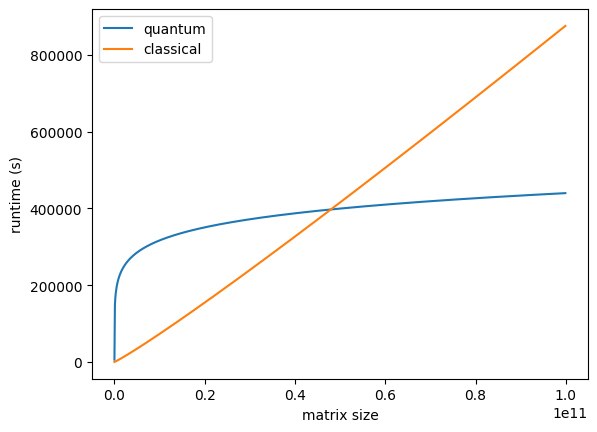

In [14]:
def plot_runtime_line_graph():
    epsilon_inv  = 10
    N_start = 1000
    N_end = 1e11
    steps = 1000
    
    N = np.arange(N_start, N_end, (N_end - N_start) / steps)
    k = np.log2(N)
    s = np.log2(N)


    q_runtime = calculate_q_runtime(k, s, epsilon_inv, N)
    c_runtime = calculate_c_runtime(k, s, epsilon_inv, N)

    fig, ax = plt.subplots()
    ax.plot(N, q_runtime, label="quantum")
    ax.plot(N, c_runtime, label="classical")
    ax.set_xlabel("matrix size")
    ax.set_ylabel("runtime (s)")
    ax.legend()
    plt.show()

plot_runtime_line_graph()

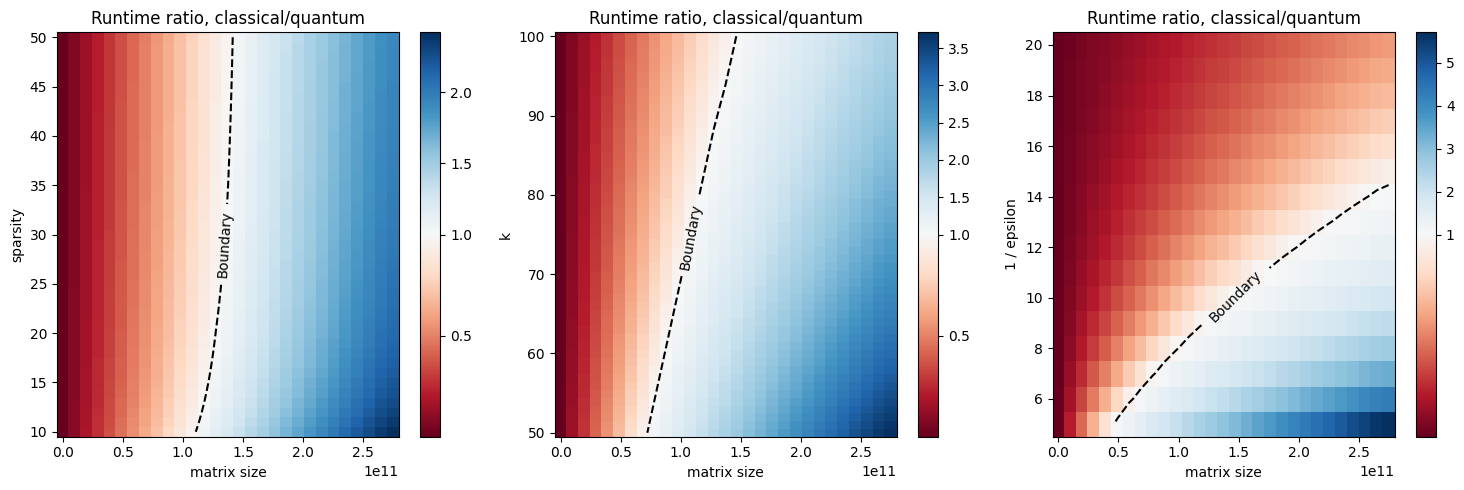

In [15]:
def plot_runtime_heatmap():  # set this function to avoid conflict variables

    def sub_plot(ax, x,y, data, title, xlabel, ylabel):
        norm = colors.TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())
        c = ax.pcolor(x, y, data, cmap="RdBu", norm=norm)
        ax.set_title(title)
        fig.colorbar(c, ax=ax)   

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        contour = ax.contour(
            x,
            y,
            data,
            levels=[1],
            colors="black",
            linewidths=1.5,
            linestyles="--",
        )
        ax.clabel(contour, fmt="Boundary", fontsize = 10,colors="black")

    def calculate_ratio(q_runtime, c_runtime, N, n_start):
        ratio = c_runtime
        for i in range(0, N.shape[0]):
            for j in range(0, N.shape[1]):
                q_j= np.floor(np.log2(N[i, j])).astype(int) - n_start
                ratio[i, j] = ratio[i, j] / q_runtime[i, q_j]
        return ratio

    s_start, s_end, ds = 10, 50, 1
    k_start, k_end, dk = 50, 100, 1
    epsilon_inv_start, epsilon_inv_end, depslilon_inv = 5, 20, 1

    fix_k, fix_epsilon_inv, fix_s = 100, 10, 100
    n_start, n_end, dn = 10, 38, 1

    # big N used by classical plot
    N_start = 2**n_start
    N_end = 2**n_end
    N_steps = n_end - n_start
    dN = (N_end - N_start) / N_steps

    fig, axs = plt.subplots(1,3,figsize=(15, 5))

    ###############################
    # n - s
    ###############################
    s, n = np.mgrid[s_start : s_end + ds : ds, n_start : n_end + dn : dn]
    _, n_s_N = np.mgrid[s_start : s_end + ds : ds, N_start : N_end + dN : dN]

    n_s_q_runtime = calculate_q_runtime(fix_k, s, fix_epsilon_inv, 2**n)
    n_s_c_runtime = calculate_c_runtime(fix_k, s, fix_epsilon_inv, n_s_N)
    n_s_ratio = calculate_ratio(n_s_q_runtime, n_s_c_runtime, n_s_N, n_start)

    sub_plot(axs[0], n_s_N, s, n_s_ratio, "Runtime ratio, classical/quantum", "matrix size", "sparsity")

    ###############################
    # k - n
    ###############################
    k, n = np.mgrid[k_start : k_end + dk : dk, n_start : n_end + dn : dn]
    _, n_k_N = np.mgrid[k_start : k_end + dk : dk, N_start : N_end + dN : dN]
    n_k_q_runtime = calculate_q_runtime(k, fix_s, fix_epsilon_inv, 2**n)
    n_k_c_runtime = calculate_c_runtime(k, fix_s, fix_epsilon_inv, n_k_N)
    n_k_ratio = calculate_ratio(n_k_q_runtime, n_k_c_runtime, n_k_N, n_start)

    sub_plot(axs[1], n_k_N, k, n_k_ratio, "Runtime ratio, classical/quantum", "matrix size", "k")

    ###############################
    # epsilon - n
    ###############################
    
    epsilon, n = np.mgrid[epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv, n_start : n_end + dn : dn]
    _, n_epsilon_N = np.mgrid[epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv, N_start : N_end + dN : dN]
    n_epsilon_q_runtime = calculate_q_runtime(fix_k, fix_s, epsilon, 2**n)
    n_epsilon_c_runtime = calculate_c_runtime(fix_k, fix_s, epsilon, n_epsilon_N)
    n_epsilon_ratio = calculate_ratio(n_epsilon_q_runtime, n_epsilon_c_runtime, n_epsilon_N, n_start)

    sub_plot(axs[2], n_epsilon_N, epsilon, n_epsilon_ratio, "Runtime ratio, classical/quantum", "matrix size", "1 / epsilon")

    plt.tight_layout()

    plt.show()


plot_runtime_heatmap()

# Energy
We estimate the quantum energy using a simple formula: "energy = runtime * physical_qubit_count * power_per_physical_qubit"

In [ ]:
# def calculate_q_energy(k,s,epsilon_inv,N):
#     runtime = calculate_q_runtime(k, s, epsilon_inv, N)
#     power_per_physical_qubit = 6.25  # very rough estimate by "Estimating the Energy Requirements to  Operate a Cryptanalytically Relevant  Quantum Computer"
#     physical